<a href="https://colab.research.google.com/github/GIRIME262/transferencia-de-estilo-neuronal/blob/main/Final_CNN_Pablo_Germ%C3%A1n_Giri_Style_Transfer_N%C2%B09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">



In [ ]:
# Imagen para estilo

!wget https://dimensionargentina.files.wordpress.com/2012/08/9391f-12594-1500x1100.jpg


# Imagen para contenido
!wget https://www.muycomputer.com/wp-content/uploads/2017/03/Deadpool-2.jpg


# Creamos el directorio para los archivos de salida
!mkdir /content/output-nueva-imagen

--2021-01-10 16:14:45--  https://dimensionargentina.files.wordpress.com/2012/08/9391f-12594-1500x1100.jpg
Resolving dimensionargentina.files.wordpress.com (dimensionargentina.files.wordpress.com)... 192.0.72.20, 192.0.72.21
Connecting to dimensionargentina.files.wordpress.com (dimensionargentina.files.wordpress.com)|192.0.72.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430450 (420K) [image/jpeg]
Saving to: ‘9391f-12594-1500x1100.jpg’

9391f-12594-1500x11 100%[===================>] 420.36K  --.-KB/s    in 0.009s  

2021-01-10 16:14:45 (48.2 MB/s) - ‘9391f-12594-1500x1100.jpg’ saved [430450/430450]

--2021-01-10 16:14:45--  https://www.muycomputer.com/wp-content/uploads/2017/03/Deadpool-2.jpg
Resolving www.muycomputer.com (www.muycomputer.com)... 151.139.245.223
Connecting to www.muycomputer.com (www.muycomputer.com)|151.139.245.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53194 (52K) [image/jpeg]
Saving to: ‘Deadpool-2.jpg

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/Deadpool-2.jpg")
style_reference_image_path = Path("/content/9391f-12594-1500x1100.jpg")
result_prefix = Path("/content/output-nueva-imagen")



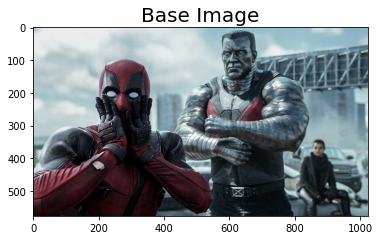

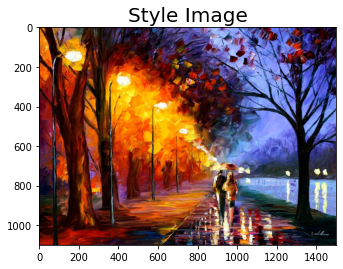

In [ ]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img('/content/Deadpool-2.jpg')
plt.imshow(img1)
plt.figure()
plt.title("Style Image",fontsize=20)
img2 = load_img('/content/9391f-12594-1500x1100.jpg')
plt.imshow(img2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')
model.summary()

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram



In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

In [ ]:
evaluator = Evaluator()
iterations =1000
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)
best_loss, best_img = float('inf'), None###

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if min_val < best_loss:
      best_loss = min_val
      best_img = x.copy()

    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 28135942000.0
Image saved as /content/output-nueva-imagen/output_at_iteration_0.png
Iteration 0 completed in 18s
Start of iteration 1
Current loss value: 12920034000.0
Image saved as /content/output-nueva-imagen/output_at_iteration_1.png
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 8936834000.0
Image saved as /content/output-nueva-imagen/output_at_iteration_2.png
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 7283994600.0
Image saved as /content/output-nueva-imagen/output_at_iteration_3.png
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 6171630600.0
Image saved as /content/output-nueva-imagen/output_at_iteration_4.png
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 5501260300.0
Image saved as /content/output-nueva-imagen/output_at_iteration_5.png
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 4984186000.0
Image saved as /content/output-

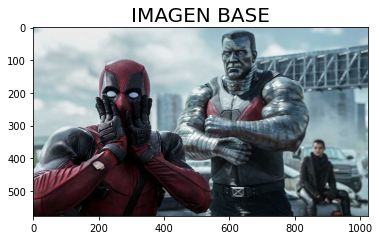

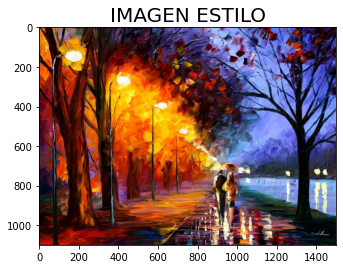

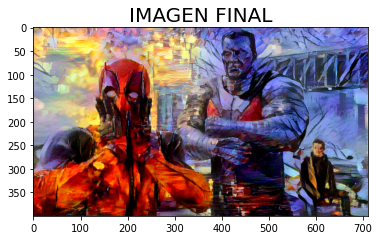

In [ ]:
plt.figure()
plt.title("IMAGEN BASE",fontsize=20)
img1 = load_img('/content/Deadpool-2.jpg')
plt.imshow(img1)

plt.figure()
plt.title("IMAGEN ESTILO",fontsize=20)
img2 = load_img('/content/9391f-12594-1500x1100.jpg')
plt.imshow(img2)

plt.figure()
plt.title("IMAGEN FINAL",fontsize=20)
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)